# 验证码识别-TFLearn 版-单字符-简化

同是从带多个字符的图片中学习特征，同时对应多个输出分类(4个字符)

# 准备数据

In [1]:
%matplotlib inline
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

image_dir = "/Volumes/Cloud/DataSet/src/captcha"
model_dir = "/Volumes/Cloud/Models/captcha/resnet"

LABEL_LENGTH = 4        # 验证码字符数
#LABELS = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
LABELS = "0123456789"   # 验证码字符组成

IMAGE_H = 28            # 缩放后单个字符图片大小
IMAGE_W = 28            # 缩放后单个字符图片大小
IMAGE_C = 3             # 图片通道数：1/3/4

# 加载模型

In [3]:
# 构造网络模型
from __future__ import absolute_import, division, print_function
import tflearn
import tensorflow as tf
import time

tf.reset_default_graph()
tflearn.config.init_training_mode()

def build_model(learning_rate):
    img_prep = tflearn.ImagePreprocessing()
    # img_prep.add_featurewise_zero_center(per_channel=True)  # 输入图像要减图像均值

    img_aug = tflearn.ImageAugmentation()
    img_aug.add_random_rotation(max_angle=10.0)  # 随机旋转角度
    # img_aug.add_random_blur(sigma_max=5.0)

    # Building Residual Network
    net = tflearn.input_data(shape=[None, IMAGE_H, IMAGE_W, IMAGE_C],
                             data_preprocessing=img_prep,
                             data_augmentation=img_aug,
                             name='input')

    net = tflearn.conv_2d(net, 16, 3,
                          regularizer='L2',
                          weights_init='variance_scaling',
                          weight_decay=0.0001,
                          name="conv1")  # 卷积处理, 16个卷积，卷积核大小为3，L2 正则化减少过拟合

    net = tflearn.residual_block(net, 1, 16, name="res1")  # 1 个残差层，输出16特征
    net = tflearn.residual_block(net, 1, 32, downsample=True, name="res2")  # 1 个残差层，输出32特征，降维1/2
    net = tflearn.residual_block(net, 1, 64, downsample=True, name="res3")  # 1 个残差层，输出64特征，降维1/2

    # Regression
    net = tflearn.fully_connected(net, len(LABELS), activation='softmax')
    mom = tflearn.Momentum(learning_rate, lr_decay=0.1, decay_step=32000, staircase=True)
    net = tflearn.regression(net, optimizer=mom, loss='categorical_crossentropy')

    # Training
    model = tflearn.DNN(net, max_checkpoints=1, tensorboard_verbose=3)

    return model

model = build_model(learning_rate=0.01)

# Load a model
model.load(model_dir +'/model.tfl')

INFO:tensorflow:Restoring parameters from /Volumes/Cloud/Models/captcha/resnet/model.tfl


# 预测

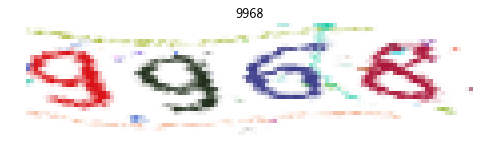

In [4]:
# 读图
def read_image(filename):
    image = cv2.imread(filename)  # 读 PNG 只会读到3个通道
    #image = mpimg.imread(filename) 
    h,w = image.shape[:2]
    image = image[0:h,12:w-6]
    image = cv2.resize(image,(IMAGE_W*LABEL_LENGTH,IMAGE_H),cv2.INTER_LINEAR) # 缩放大小
    return image

# 切分图片
def split_image(image):
    images = []
    h = image.shape[0]
    sw = IMAGE_W
    for i in range(LABEL_LENGTH):
        x = sw*i
        images.append(image[0:h,x:x+sw])

    return images

# 验证码去燥
def remove_noise(image):
    return image

# 预测
def predict(image):
    def onehot2number(label):
        return LABELS[np.argmax(label)]

    image = image.astype(np.float32)
    image = image/255.0

    x_data = split_image(image)

    y_preds = model.predict(x_data)

    label = ''
    for y_pred in y_preds:
        label = label + onehot2number(y_pred)
    
    return label

import random
files = os.listdir(image_dir)
filename=os.path.join(image_dir,files[random.randint(0,len(files))])
image = read_image(filename)
label = predict(image)

plt.figure(figsize=(8,3))
plt.axis('off');
plt.imshow(image)
plt.title(label)
plt.show()